<a href="https://colab.research.google.com/github/younesabdolmalaky/A-Dual-Channel-Approach-for-Farsi-Text-Classification-using-Transfer-Learning-Techniques/blob/main/TFIDF_DMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download bittlingmayer/amazonreviews
! unzip amazonreviews.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 490M/493M [00:13<00:00, 42.1MB/s]
100% 493M/493M [00:13<00:00, 38.4MB/s]
Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import models, layers, optimizers
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import bz2
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import re

In [ ]:
import numpy as np
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.sparse import reorder
from tensorflow import SparseTensor
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense
from tensorflow.keras.utils import plot_model
import pickle
from sklearn.metrics import classification_report
from tensorflow.sparse import concat
import tensorflow as tf

In [ ]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
    return np.array(labels), texts
train_labels, train_texts = get_labels_and_texts('train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('test.ft.txt.bz2')

In [ ]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
        lower = text.lower()
        no_punctuation = NON_ALPHANUM.sub(r' ', lower)
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        normalized_texts.append(no_non_ascii)
    return normalized_texts
        
train_texts = normalize_texts(train_texts)
test_texts = normalize_texts(test_texts)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_train.shape

(3600000, 905917)

In [ ]:
X_test = vectorizer.transform(test_texts)

In [ ]:
del test_texts
del train_texts

In [ ]:
y_train = train_labels
y_test = test_labels

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
FS = SelectKBest(f_classif, k=1000)
X_f_class = FS.fit_transform(X_train, y_train)
X_f_class.shape

(3600000, 1000)

In [ ]:
X_f_class_test = FS.transform(X_test)

In [ ]:
del X_train 
del X_test

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return SparseTensor(indices, coo.data, coo.shape)

In [ ]:
traindata = reorder(convert_sparse_matrix_to_sparse_tensor(X_f_class))
testdata = reorder(convert_sparse_matrix_to_sparse_tensor(X_f_class_test))

In [ ]:
del X_f_class
del X_f_class_test

In [ ]:
tfidf = Input(shape=(1000,))
x1 = layers.Dense(128, activation='relu')(tfidf)
x1 = layers.Dense(64, activation='relu')(x1)
outputs = Dense(1, activation='sigmoid')(x1)
model = Model(inputs=tfidf, outputs=outputs)

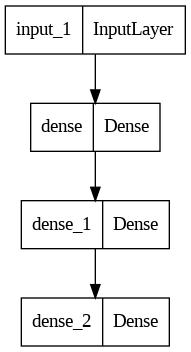

In [ ]:
plot_model(model)

In [ ]:
mch = callbacks.ModelCheckpoint('../models/fianl-model.h5' , monitor='accuracy' , mode ='max' , save_best_only=True)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
batch_size =128
model.fit(traindata, y_train, batch_size=batch_size, epochs=10 , callbacks=[mch] ,validation_data = (testdata ,y_test ) )

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


28125/28125 [==============================] - 167s 6ms/step - loss: 0.2400 - accuracy: 0.9006 - val_loss: 0.2296 - val_accuracy: 0.9056
Epoch 2/10
28125/28125 [==============================] - 163s 6ms/step - loss: 0.2227 - accuracy: 0.9085 - val_loss: 0.2248 - val_accuracy: 0.9075
Epoch 3/10
28125/28125 [==============================] - 159s 5ms/step - loss: 0.2159 - accuracy: 0.9117 - val_loss: 0.2237 - val_accuracy: 0.9080
Epoch 4/10
28125/28125 [==============================] - 156s 5ms/step - loss: 0.2114 - accuracy: 0.9136 - val_loss: 0.2243 - val_accuracy: 0.9085
Epoch 5/10
28125/28125 [==============================] - 157s 5ms/step - loss: 0.2082 - accuracy: 0.9151 - val_loss: 0.2255 - val_accuracy: 0.9082
Epoch 6/10
28125/28125 [==============================] - 158s 5ms/step - loss: 0.2056 - accuracy: 0.9163 - val_loss: 0.2258 - val_accuracy: 0.9073
Epoch 7/10
28125/28125 [==============================] - 156s 5ms/step - loss: 0.2035 - accuracy: 0.9172 - val_loss: 0.227